# Data Science Project: Fear & Greed Web3 Trader Analysis
**Author**: Syed mohsin    **Date**: October 23, 2025

**Objective**: Analyze the relationship between trader behavior (profitability, activity) and market sentiment (Fear & Greed Index).

# STEP 1: SETUP, IMPORTS, & HELPER FUNCTIONS

In [1]:

# --- 1. Import Core Libraries ---
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates

# --- 2. Import Statistics Libraries ---
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# --- 3. Import Modeling Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score
)

# --- 4. Install Required Packages ---
print("Installing required libraries (gdown, scikit-learn)...")
!pip install gdown pandas numpy matplotlib seaborn scipy scikit-learn -q
print("Libraries installed.")

# --- 5. Create Required Directories ---
print("Creating required directories 'csv_files/' and 'outputs/'...")
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
print("Directories are ready.")

# --- 6. Define Global Plotting Style ---
sns.set(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

# --- 7. Create Helper Function to Save Plots ---
def save_plot(filename, fig=None, dpi=300):
    """
    Saves the current or specified matplotlib figure to the 'outputs/' directory.
    """
    save_path = os.path.join("outputs", filename)

    # Use the provided figure object or get the current global figure
    if fig:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    else:
        # If no fig is passed, get the current figure
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    print(f"Plot saved to: {save_path}")

print("\n--- Setup Complete ---")

Installing required libraries (gdown, scikit-learn)...
Libraries installed.
Creating required directories 'csv_files/' and 'outputs/'...
Directories are ready.

--- Setup Complete ---


# STEP 2: DATA ACQUISITION

In this step, we download the two required datasets from Google Drive using gdown and store them in our csv_files/ directory. We then load them into pandas DataFrames.

In [2]:
print("Starting Step 2: Data Acquisition...")

# --- 1. Define Google Drive File IDs and Output Paths ---
gdrive_files = {
    "historical_data.csv": "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs",
    "fear_greed_index.csv": "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
}

path_trades = os.path.join("csv_files", "historical_data.csv")
path_sentiment = os.path.join("csv_files", "fear_greed_index.csv")

# --- 2. Download Files using gdown ---
print(f"Downloading Historical Trader Data...")
!gdown --id {gdrive_files['historical_data.csv']} -O {path_trades}

print(f"\nDownloading Fear & Greed Index...")
!gdown --id {gdrive_files['fear_greed_index.csv']} -O {path_sentiment}
print("\nDownloads complete.")

# --- 3. Load Datasets into Pandas DataFrames ---
print("\nLoading CSV files into pandas DataFrames...")
try:
    df_trades = pd.read_csv(path_trades)
    df_sentiment = pd.read_csv(path_sentiment)
    print("Files loaded successfully.")
except FileNotFoundError:
    print("\nERROR: Files not found. Please check the download step.")
except Exception as e:
    print(f"\nAn error occurred while loading the files: {e}")

# --- 4. Initial Inspection ---
print("\n--- Historical Trader Data (df_trades) Head ---")
display(df_trades.head())

print("\n--- Fear & Greed Index (df_sentiment) Head ---")
display(df_sentiment.head())

print("\n--- Step 2 Complete ---")

Starting Step 2: Data Acquisition...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/csv_files/historical_data.csv
100% 47.5M/47.5M [00:00<00:00, 74.0MB/s]

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/csv_files/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 53.2MB/s]

Downloads complete.

Loading CSV files into pandas DataFrames...
Files loaded successfully.

--- Historical Trader Data (df_trades) Head ---


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



--- Fear & Greed Index (df_sentiment) Head ---


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



--- Step 2 Complete ---


# STEP 3: INITIAL EXPLORATORY DATA ANALYSIS (EDA)

Here, we perform a basic health check on both DataFrames. We look at their shape, check for missing values, identify duplicates, and inspect the data types (.info()) and summary statistics (.describe()).

In [3]:

print("Starting Step 3: Initial EDA...")

# --- 1. Analyze Historical Trader Data (df_trades) ---
print("\n" + "="*50)
print("Analysis of Historical Trader Data (df_trades)")
print("="*50)

print("\n--- (1a) DataFrame Info (df_trades) ---")
df_trades.info()

print("\n\n--- (1b) Missing Values (df_trades) ---")
print(df_trades.isnull().sum())

print("\n\n--- (1c) Duplicate Rows (df_trades) ---")
duplicates_trades = df_trades.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_trades}")

print("\n\n--- (1d) Descriptive Statistics (df_trades) ---")
display(df_trades.describe())

# --- 2. Analyze Fear & Greed Index (df_sentiment) ---
print("\n" + "="*50)
print("Analysis of Fear & Greed Index (df_sentiment)")
print("="*50)

print("\n--- (2a) DataFrame Info (df_sentiment) ---")
df_sentiment.info()

print("\n\n--- (2b) Missing Values (df_sentiment) ---")
print(df_sentiment.isnull().sum())

print("\n\n--- (2c) Duplicate Rows (df_sentiment) ---")
duplicates_sentiment_date = df_sentiment.duplicated(subset=['date']).sum()
print(f"Number of duplicate dates: {duplicates_sentiment_date}")

print("\n\n--- (2d) Unique 'classification' values ---")
print(df_sentiment['classification'].unique())

print("\n--- Step 3 Complete ---")

Starting Step 3: Initial EDA...

Analysis of Historical Trader Data (df_trades)

--- (1a) DataFrame Info (df_trades) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64


,Execution Price,Size Tokens,Size USD,Start Position,Closed PnL,Order ID,Fee,Trade ID,Timestamp
count,211224.000000,2.112240e+05,2.112240e+05,2.112240e+05,211224.000000,2.112240e+05,211224.000000,2.112240e+05,2.112240e+05
mean,11414.723350,4.623365e+03,5.639451e+03,-2.994625e+04,48.749001,6.965388e+10,1.163967,5.628549e+14,1.737744e+12
std,29447.654868,1.042729e+05,3.657514e+04,6.738074e+05,919.164828,1.835753e+10,6.758854,3.257565e+14,8.689920e+09
min,0.000005,8.740000e-07,0.000000e+00,-1.433463e+07,-117990.104100,1.732711e+08,-1.175712,0.000000e+00,1.680000e+12
25%,4.854700,2.940000e+00,1.937900e+02,-3.762311e+02,0.000000,5.983853e+10,0.016121,2.810000e+14,1.740000e+12
50%,18.280000,3.200000e+01,5.970450e+02,8.472793e+01,0.000000,7.442939e+10,0.089578,5.620000e+14,1.740000e+12
75%,101.580000,1.879025e+02,2.058960e+03,9.337278e+03,5.792797,8.335543e+10,0.393811,8.460000e+14,1.740000e+12
max,109004.000000,1.582244e+07,3.921431e+06,3.050948e+07,135329.090100,9.014923e+10,837.471593,1.130000e+15,1.750000e+12



Analysis of Fear & Greed Index (df_sentiment)

--- (2a) DataFrame Info (df_sentiment) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


--- (2b) Missing Values (df_sentiment) ---
timestamp         0
value             0
classification    0
date              0
dtype: int64


--- (2c) Duplicate Rows (df_sentiment) ---
Number of duplicate dates: 0


--- (2d) Unique 'classification' values ---
['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']

--- Step 3 Complete ---


# STEP 4: DATA CLEANING

Based on the initial EDA, we clean the data.

For df_trades:

*Convert Timestamp IST to datetime objects.

*Create a trade_date (normalized) column for merging.

*Filter for PnL-generating trades only (Closed PnL != 0). This isolates closing trades, liquidations, etc.

*Standardize text columns (Side, Coin) to lowercase.

For df_sentiment:

*Convert date to a datetime object.

*Simplify classification into a new sentiment column ('Fear', 'Greed', 'Neutral').

In [4]:

print("Starting Step 4: Data Cleaning...")

# --- 1. Clean Historical Trader Data (df_trades) ---
print("\nCleaning df_trades...")
df_trades_cleaned = df_trades.copy()

# Convert 'Timestamp IST' to datetime
try:
    df_trades_cleaned['timestamp_dt'] = pd.to_datetime(df_trades_cleaned['Timestamp IST'], format='%d-%m-%Y %H:%M')
    print("'Timestamp IST' converted to datetime.")
except Exception as e:
    print(f"Error converting 'Timestamp IST' with format: {e}. Trying auto-inference.")
    df_trades_cleaned['timestamp_dt'] = pd.to_datetime(df_trades_cleaned['Timestamp IST'], infer_datetime_format=True)

# Create a 'trade_date' column (normalized to midnight) for merging
df_trades_cleaned['trade_date'] = df_trades_cleaned['timestamp_dt'].dt.normalize()

# Filter for PnL-generating trades (where Closed PnL is not zero)
initial_rows = df_trades_cleaned.shape[0]
df_trades_cleaned = df_trades_cleaned[df_trades_cleaned['Closed PnL'] != 0].copy()
final_rows = df_trades_cleaned.shape[0]
print(f"Filtered for PnL-generating trades: {initial_rows} rows -> {final_rows} rows")

# Standardize categorical text
df_trades_cleaned['Side'] = df_trades_cleaned['Side'].str.lower().str.strip()
df_trades_cleaned['Coin'] = df_trades_cleaned['Coin'].str.lower().str.strip()
print("Standardized 'Side' and 'Coin' columns.")

# --- 2. Clean Fear & Greed Index (df_sentiment) ---
print("\nCleaning df_sentiment...")
df_sentiment_cleaned = df_sentiment.copy()

# Convert 'date' to datetime
df_sentiment_cleaned['date'] = pd.to_datetime(df_sentiment_cleaned['date'])
print("'date' column converted to datetime.")

# Create the simplified 'sentiment' column
def map_sentiment(classification):
    if classification in ['Extreme Fear', 'Fear']:
        return 'Fear'
    elif classification in ['Extreme Greed', 'Greed']:
        return 'Greed'
    else:
        return 'Neutral'

df_sentiment_cleaned['sentiment'] = df_sentiment_cleaned['classification'].apply(map_sentiment)
print("Created simplified 'sentiment' column.")

print("\n--- New 'sentiment' Value Counts ---")
print(df_sentiment_cleaned['sentiment'].value_counts())

print("\n--- Step 4 Complete ---")

Starting Step 4: Data Cleaning...

Cleaning df_trades...
'Timestamp IST' converted to datetime.
Filtered for PnL-generating trades: 211224 rows -> 104408 rows
Standardized 'Side' and 'Coin' columns.

Cleaning df_sentiment...
'date' column converted to datetime.
Created simplified 'sentiment' column.

--- New 'sentiment' Value Counts ---
sentiment
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64

--- Step 4 Complete ---


# STEP 5: FEATURE ENGINEERING & MERGING

Now we combine our two datasets and create our final features for analysis.

**1.Feature** Engineering: Create is_profitable (True/False) and pnl_per_usd_size (PnL / Size USD).

**2.Note on Leverage**: The leverage column was specified in instructions but is not in the dataset. Leverage-based analysis will be skipped.

**3.Merge**: Perform a left merge, joining df_sentiment_cleaned onto df_trades_cleaned using our date keys.

**4.Handle Missing Data**: We ffill (forward-fill) sentiment data for any trades that occurred on weekends or holidays where the index wasn't updated.

**5.Filter**: Remove 'Neutral' days to focus the analysis on 'Fear' vs. 'Greed'.

**6.Save**: Save the final df_merged DataFrame to csv_files/merged_trade_data.csv.

In [5]:

print("Starting Step 5: Feature Engineering & Merging...")

# --- 1. Feature Engineering (on df_trades_cleaned) ---
print("\nCreating new features for df_trades_cleaned...")
df_trades_cleaned['is_profitable'] = df_trades_cleaned['Closed PnL'] > 0
df_trades_cleaned['pnl_per_usd_size'] = df_trades_cleaned.apply(
    lambda row: row['Closed PnL'] / row['Size USD'] if row['Size USD'] != 0 else 0,
    axis=1
)
print("New features 'is_profitable' and 'pnl_per_usd_size' created.")
print("Note: 'leverage' column not found, so 'lev_bucket' will not be created.")

# --- 2. Merge Trade Data with Sentiment Data ---
print("\nMerging trader data with sentiment data...")
df_merged = pd.merge(
    df_trades_cleaned,
    df_sentiment_cleaned[['date', 'sentiment', 'value']], # Select only needed columns
    left_on='trade_date',
    right_on='date',
    how='left'
)
df_merged = df_merged.drop(columns=['date'])
print(f"Merge complete. Merged DataFrame shape: {df_merged.shape}")

# --- 3. Handle Missing Sentiment Values ---
missing_pre_fill = df_merged['sentiment'].isnull().sum()
print(f"Trades with missing sentiment (pre-fill): {missing_pre_fill}")
if missing_pre_fill > 0:
    df_merged = df_merged.sort_values(by='timestamp_dt')
    df_merged['sentiment'] = df_merged['sentiment'].ffill()
    df_merged['value'] = df_merged['value'].ffill()
    print("Applied forward-fill (ffill) to 'sentiment' and 'value' columns.")

    # Drop any remaining NaNs (e.g., trades before sentiment data began)
    df_merged = df_merged.dropna(subset=['sentiment'])

# --- 4. Filter for 'Fear' vs. 'Greed' ---
print(f"\nOriginal 'sentiment' counts:\n{df_merged['sentiment'].value_counts(dropna=False)}")
df_merged = df_merged[df_merged['sentiment'] != 'Neutral'].copy()
print(f"\nFiltered 'sentiment' counts (Fear vs. Greed):\n{df_merged['sentiment'].value_counts()}")

# --- 5. Save Final Merged Data ---
output_path_merged = os.path.join("csv_files", "merged_trade_data.csv")
df_merged.to_csv(output_path_merged, index=False)
print(f"\nFinal merged and cleaned data saved to: {output_path_merged}")

# --- 6. Final Inspection ---
print("\n--- Final Merged Data (df_merged) Head ---")
display(df_merged.head())

print("\n--- Step 5 Complete ---")

Starting Step 5: Feature Engineering & Merging...

Creating new features for df_trades_cleaned...
New features 'is_profitable' and 'pnl_per_usd_size' created.
Note: 'leverage' column not found, so 'lev_bucket' will not be created.

Merging trader data with sentiment data...
Merge complete. Merged DataFrame shape: (104408, 22)
Trades with missing sentiment (pre-fill): 6
Applied forward-fill (ffill) to 'sentiment' and 'value' columns.

Original 'sentiment' counts:
sentiment
Greed      46035
Fear       40214
Neutral    18159
Name: count, dtype: int64

Filtered 'sentiment' counts (Fear vs. Greed):
sentiment
Greed    46035
Fear     40214
Name: count, dtype: int64

Final merged and cleaned data saved to: csv_files/merged_trade_data.csv

--- Final Merged Data (df_merged) Head ---


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,timestamp_dt,trade_date,is_profitable,pnl_per_usd_size,sentiment,value
21022,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,eth,2252.300,11.21190,25252.56,sell,14-12-2023 01:20,11.21190,Close Long,245.428491,...,True,6.313140,6.790000e+14,1.700000e+12,2023-12-14 01:20:00,2023-12-14,True,0.009719,Greed,72.0
21020,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,btc,42748.000,0.01500,641.22,buy,14-12-2023 01:20,-0.59711,Close Short,-13.230000,...,True,0.160305,8.320000e+14,1.700000e+12,2023-12-14 01:20:00,2023-12-14,False,-0.020633,Greed,72.0
21021,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,btc,42749.000,0.58211,24884.62,buy,14-12-2023 01:20,-0.58211,Close Short,-514.003130,...,True,6.221155,4.890000e+14,1.700000e+12,2023-12-14 01:20:00,2023-12-14,False,-0.020655,Greed,72.0
21024,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,aave,99.370,102.84000,10219.21,sell,14-12-2023 23:28,170.81000,Close Long,30.625752,...,True,2.554802,1.730000e+14,1.700000e+12,2023-12-14 23:28:00,2023-12-14,True,0.002997,Greed,72.0
21025,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,aave,99.349,67.97000,6752.75,sell,14-12-2023 23:28,67.97000,Close Long,18.814096,...,True,1.688187,2.670000e+14,1.700000e+12,2023-12-14 23:28:00,2023-12-14,True,0.002786,Greed,72.0



--- Step 5 Complete ---


# STEP 6: EXPLORATORY DATA ANALYSIS (VISUALIZATION)

With our final df_merged dataset, we can now create the core visualizations for our report. All plots are saved to the outputs/ directory.

**Plot 1**: PnL Distribution: A boxplot and histogram to see the spread of PnL, clipped for readability.

**Plot 2**: Profitability vs. Sentiment: A bar chart showing the percentage of profitable trades in 'Fear' vs. 'Greed'.

**Plot 3** : Cumulative PnL Trend: A line chart showing the total PnL over time for each sentiment group.

**Plot 4**: Coin-Sentiment Heatmap: A heatmap of mean PnL for the top 15 most traded coins.

Starting Step 6: Exploratory Data Analysis (EDA)...

Generating Plot 1: PnL Distribution...
Plot saved to: outputs/pnl_distribution_plot.png


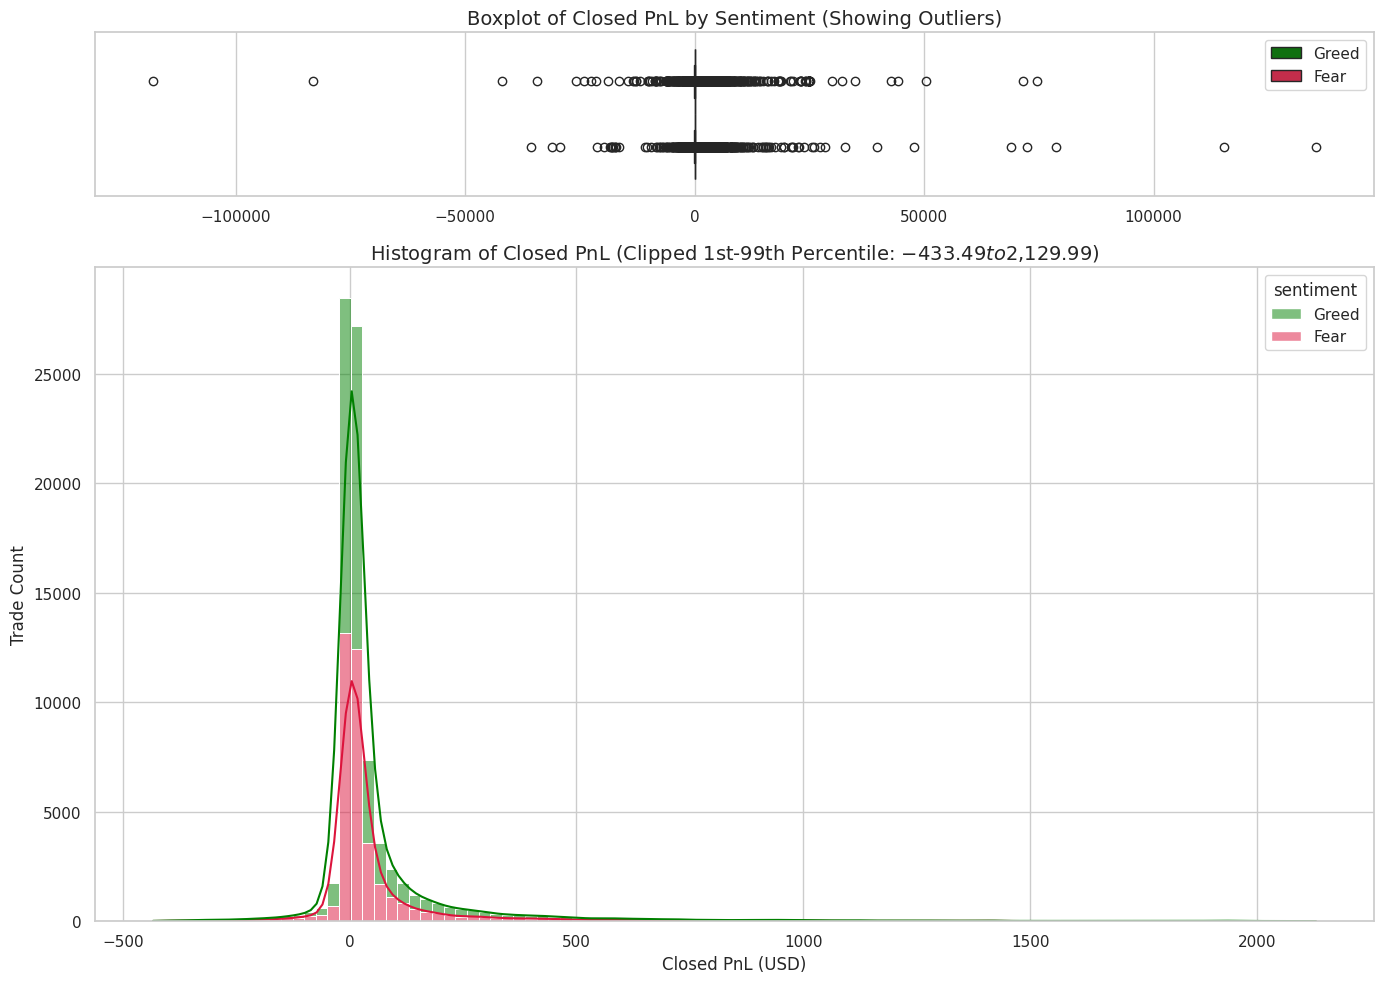


Generating Plot 2: Profitability vs. Sentiment...


/tmp/ipython-input-720837748.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Plot saved to: outputs/profitability_vs_sentiment_barchart.png


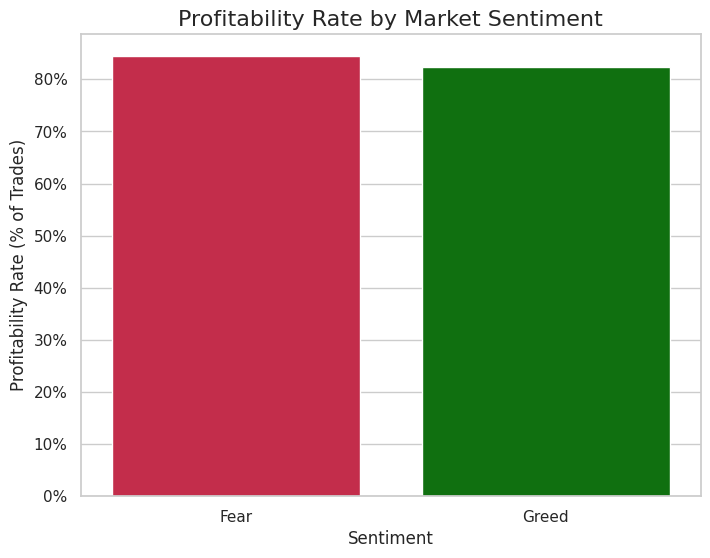


Generating Plot 3: Cumulative PnL Trend Line...
Plot saved to: outputs/daily_cumulative_pnl_trend.png


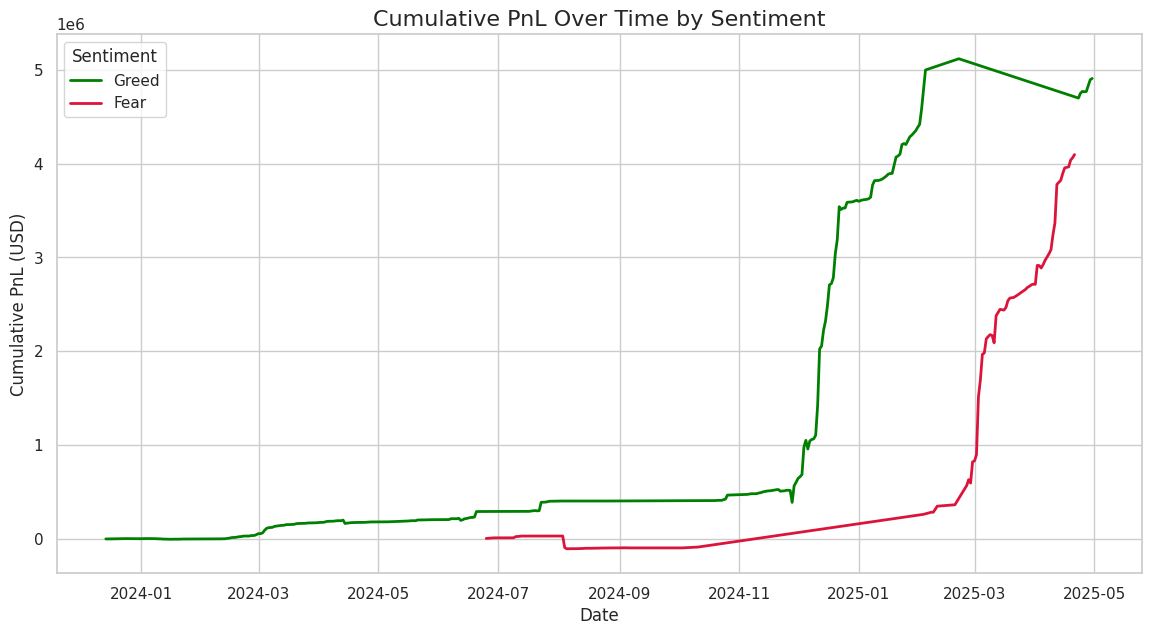


Generating Plot 4: Coin-Sentiment Heatmap...
Plot saved to: outputs/coin_sentiment_pnl_heatmap.png


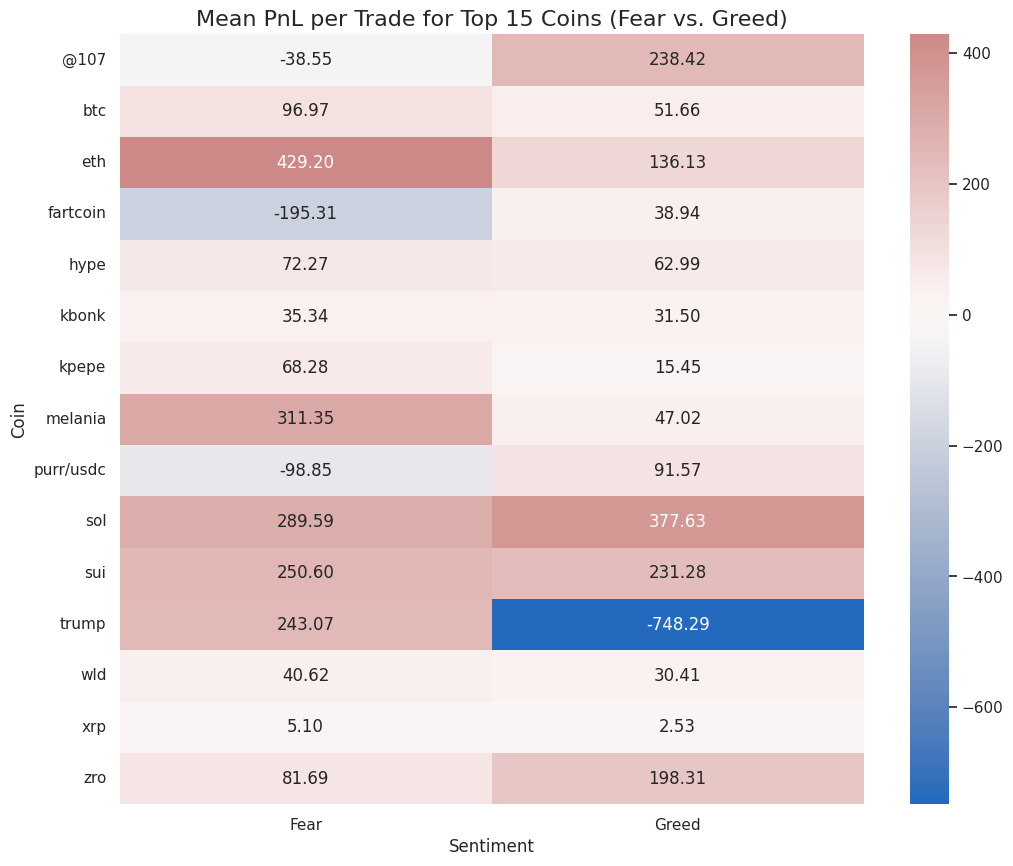


--- Step 6 Complete ---


In [6]:

print("Starting Step 6: Exploratory Data Analysis (EDA)...")

# --- 1. Plot 1: PnL Distribution (Boxplot & Clipped Histogram) ---
print("\nGenerating Plot 1: PnL Distribution...")
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(14, 10),
                                      gridspec_kw={'height_ratios': [1, 4]})

# (a) Boxplot (to show full range and outliers)
sns.boxplot(x=df_merged['Closed PnL'], hue=df_merged['sentiment'], ax=ax_box,
            palette={'Fear': 'crimson', 'Greed': 'green'})
ax_box.set_title('Boxplot of Closed PnL by Sentiment (Showing Outliers)', fontsize=14)
ax_box.set_xlabel('')
ax_box.legend(loc='upper right')

# (b) Histogram (clipped for readability)
p01 = df_merged['Closed PnL'].quantile(0.01)
p99 = df_merged['Closed PnL'].quantile(0.99)
pnl_clipped = df_merged[(df_merged['Closed PnL'] >= p01) &
                        (df_merged['Closed PnL'] <= p99)]

sns.histplot(pnl_clipped, x='Closed PnL', hue='sentiment', bins=100,
             kde=True, ax=ax_hist, multiple="stack",
             palette={'Fear': 'crimson', 'Greed': 'green'})
ax_hist.set_title(f'Histogram of Closed PnL (Clipped 1st-99th Percentile: ${p01:,.2f} to ${p99:,.2f})',
                  fontsize=14)
ax_hist.set_xlabel('Closed PnL (USD)')
ax_hist.set_ylabel('Trade Count')
plt.tight_layout()
save_plot("pnl_distribution_plot.png", fig=fig)
plt.show()
plt.close(fig)


# --- 2. Plot 2: Profitability vs. Sentiment (Bar Chart) ---
print("\nGenerating Plot 2: Profitability vs. Sentiment...")
fig, ax = plt.subplots(figsize=(8, 6))

profit_rate = df_merged.groupby('sentiment')['is_profitable'].mean().reset_index()
profit_rate = profit_rate.sort_values(by='is_profitable', ascending=False)

sns.barplot(
    data=profit_rate,
    x='sentiment',
    y='is_profitable',
    ax=ax,
    palette={'Fear': 'crimson', 'Greed': 'green'}
)

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title('Profitability Rate by Market Sentiment', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Profitability Rate (% of Trades)', fontsize=12)
save_plot("profitability_vs_sentiment_barchart.png", fig=fig)
plt.show()
plt.close(fig)


# --- 3. Plot 3: Cumulative PnL Trend Line ---
print("\nGenerating Plot 3: Cumulative PnL Trend Line...")
fig, ax = plt.subplots(figsize=(14, 7))

df_daily_pnl = df_merged.groupby(['trade_date', 'sentiment'])['Closed PnL'].sum().reset_index()
df_daily_pnl = df_daily_pnl.sort_values(by='trade_date')
df_daily_pnl['cumulative_pnl'] = df_daily_pnl.groupby('sentiment')['Closed PnL'].cumsum()

sns.lineplot(
    data=df_daily_pnl,
    x='trade_date',
    y='cumulative_pnl',
    hue='sentiment',
    palette={'Fear': 'crimson', 'Greed': 'green'},
    lw=2,
    ax=ax
)

ax.set_title('Cumulative PnL Over Time by Sentiment', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative PnL (USD)', fontsize=12)
ax.legend(title='Sentiment')
save_plot("daily_cumulative_pnl_trend.png", fig=fig)
plt.show()
plt.close(fig)


# --- 4. Plot 4: Coin vs. Sentiment Heatmap (Mean PnL) ---
print("\nGenerating Plot 4: Coin-Sentiment Heatmap...")
fig, ax = plt.subplots(figsize=(12, 10))

top_coins = df_merged['Coin'].value_counts().head(15).index.tolist()
df_top_coins = df_merged[df_merged['Coin'].isin(top_coins)]

pnl_pivot = df_top_coins.pivot_table(
    index='Coin',
    columns='sentiment',
    values='Closed PnL',
    aggfunc='mean'
)

sns.heatmap(
    pnl_pivot,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    ax=ax
)

ax.set_title('Mean PnL per Trade for Top 15 Coins (Fear vs. Greed)', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Coin', fontsize=12)
save_plot("coin_sentiment_pnl_heatmap.png", fig=fig)
plt.show()
plt.close(fig)

print("\n--- Step 6 Complete ---")

# STEP 7: STATISTICAL ANALYSIS

Here we use formal statistical tests to validate our visual findings. We set a significance level of $\alpha = 0.05$.

**Mann-Whitney U Test**: We use this non-parametric test (since PnL is not normally distributed) to check if the distributions of PnL are significantly different between 'Fear' and 'Greed'.

**Chi-Square Tes**t: We use this test to check if there is a significant association between sentiment ('Fear'/'Greed') and the categorical outcome is_profitable (True/False).

In [7]:

print("Starting Step 7: Statistical Analysis...")

# Set our significance level (alpha)
alpha = 0.05
print(f"Significance level (alpha) set to {alpha}")

# --- 1. Test 1: PnL Distribution (Mann-Whitney U Test) ---
print("\n" + "="*50)
print("Test 1: Mann-Whitney U Test for PnL Distribution")
print("="*50)
print("H0: The distribution of 'Closed PnL' is the same for 'Fear' and 'Greed'.")
print("H1: The distribution of 'Closed PnL' is different for 'Fear' and 'Greed'.")

pnl_fear = df_merged[df_merged['sentiment'] == 'Fear']['Closed PnL']
pnl_greed = df_merged[df_merged['sentiment'] == 'Greed']['Closed PnL']

print(f"\nMedian PnL (Fear):  ${pnl_fear.median():,.2f}")
print(f"Median PnL (Greed): ${pnl_greed.median():,.2f}")

u_stat, p_value_mw = mannwhitneyu(pnl_fear, pnl_greed, alternative='two-sided')

print(f"\nU-Statistic: {u_stat:,.0f}")
print(f"P-Value: {p_value_mw}")

if p_value_mw < alpha:
    print("Conclusion: REJECT H0. The PnL distributions are statistically different.")
else:
    print("Conclusion: FAIL TO REJECT H0. No significant difference in PnL distributions.")

# --- 2. Test 2: Profitability Proportions (Chi-Square Test) ---
print("\n" + "="*50)
print("Test 2: Chi-Square Test for Profitability Proportions")
print("="*50)
print("H0: 'sentiment' and 'is_profitable' are independent.")
print("H1: 'sentiment' and 'is_profitable' are not independent.")

contingency_table = pd.crosstab(df_merged['sentiment'], df_merged['is_profitable'])
print("\nContingency Table (Observed Frequencies):")
print(contingency_table)

chi2_stat, p_value_chi2, dof, expected_freq = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2_stat:,.2f}")
print(f"P-Value: {p_value_chi2}")

if p_value_chi2 < alpha:
    print("Conclusion: REJECT H0. There is a significant association between sentiment and profitability.")
else:
    print("Conclusion: FAIL TO REJECT H0. No significant association found.")

print("\n--- Step 7 Complete ---")

Starting Step 7: Statistical Analysis...
Significance level (alpha) set to 0.05

Test 1: Mann-Whitney U Test for PnL Distribution
H0: The distribution of 'Closed PnL' is the same for 'Fear' and 'Greed'.
H1: The distribution of 'Closed PnL' is different for 'Fear' and 'Greed'.

Median PnL (Fear):  $6.36
Median PnL (Greed): $6.49

U-Statistic: 923,220,353
P-Value: 0.5096241347902469
Conclusion: FAIL TO REJECT H0. No significant difference in PnL distributions.

Test 2: Chi-Square Test for Profitability Proportions
H0: 'sentiment' and 'is_profitable' are independent.
H1: 'sentiment' and 'is_profitable' are not independent.

Contingency Table (Observed Frequencies):
is_profitable  False  True 
sentiment                  
Fear            6264  33950
Greed           8077  37958

Chi-Square Statistic: 59.87
P-Value: 1.0150524753236324e-14
Conclusion: REJECT H0. There is a significant association between sentiment and profitability.

--- Step 7 Complete ---


# STEP 8: ROLLING & TIME-SERIES ANALYSIS

To identify macro trends, we aggregate our data by day and calculate 7-day rolling averages for PnL and trade count. We then plot these rolling averages against the numeric F&G index, using shaded "zones" to represent 'Fear' (F&G < 50) and 'Greed' (F&G >= 50).

Starting Step 8: Rolling & Time-Series Analysis...

Aggregating data by day...
Daily aggregation complete.
Calculated 7-day rolling averages.

Generating Plot 5: 7-Day Rolling PnL vs. Sentiment Zones...
Plot saved to: outputs/rolling_pnl_vs_sentiment.png


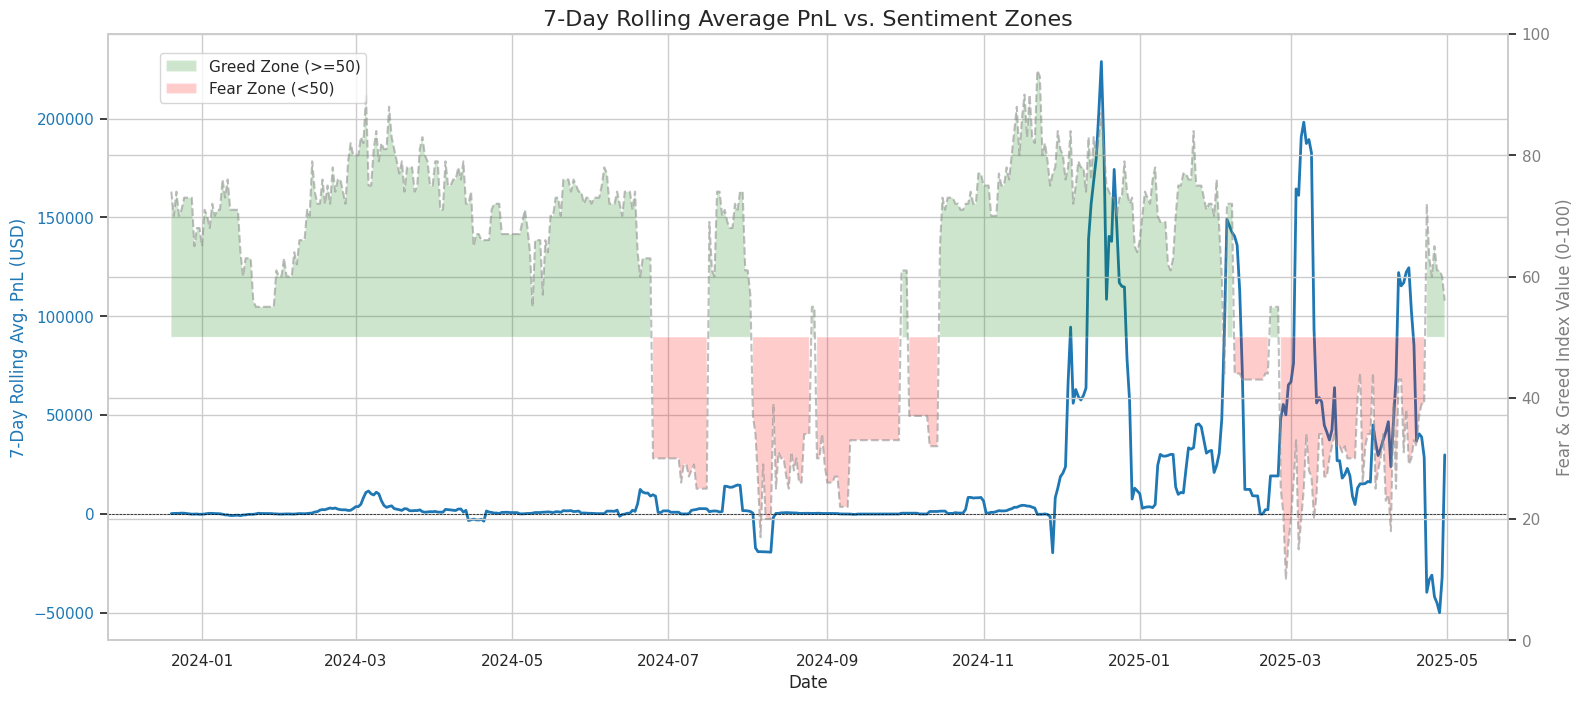


Generating Plot 6: 7-Day Rolling Trade Count vs. Sentiment Zones...
Plot saved to: outputs/rolling_trades_vs_sentiment.png


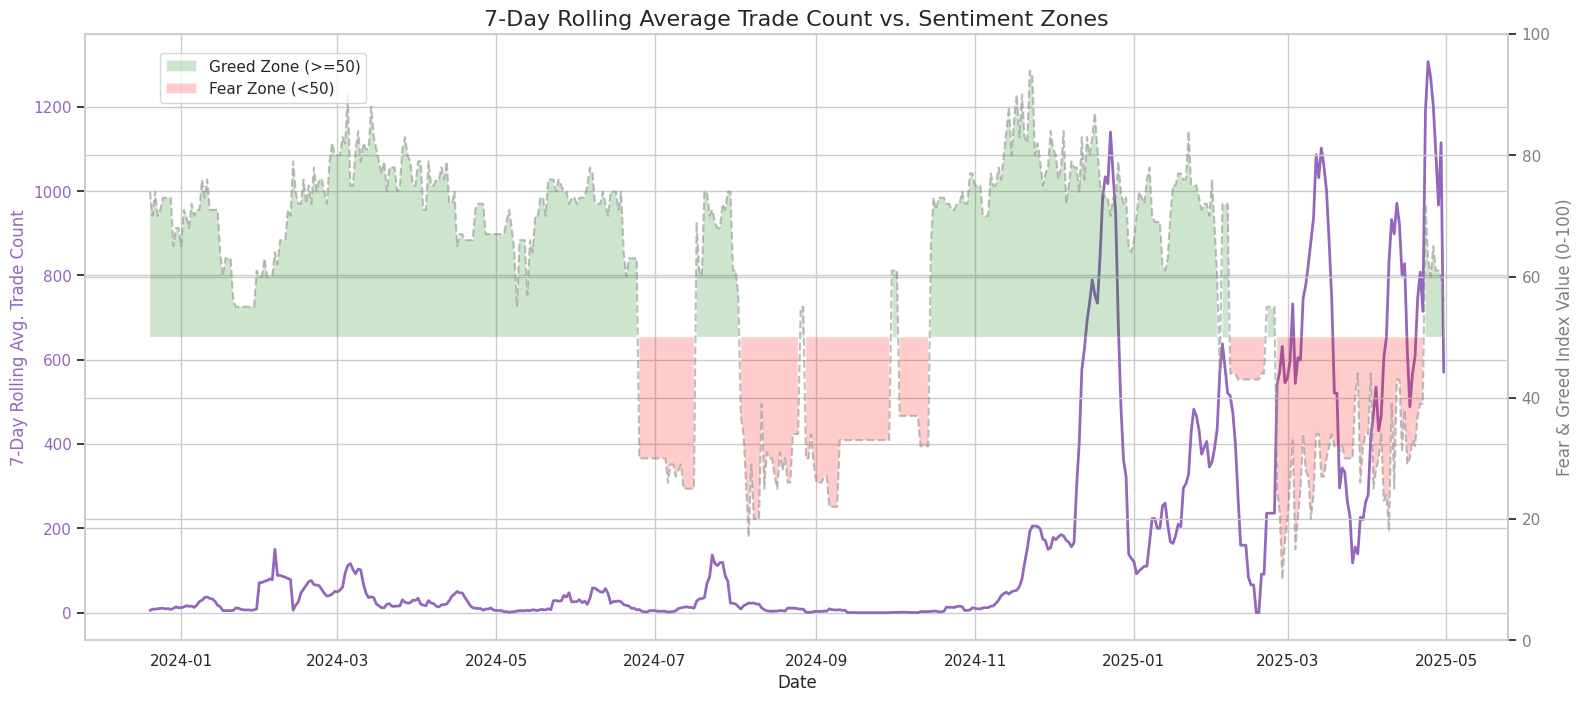


--- Step 8 Complete ---


In [8]:


print("Starting Step 8: Rolling & Time-Series Analysis...")

# --- 1. Aggregate Data by Day ---
print("\nAggregating data by day...")
df_daily = df_merged.groupby('trade_date').agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Account', 'size'),
    fng_value=('value', 'first')  # 'value' is the numeric F&G score
)

# Re-index to ensure all days are present (crucial for rolling averages)
all_days = pd.date_range(start=df_daily.index.min(), end=df_daily.index.max())
df_daily = df_daily.reindex(all_days, fill_value=0)

# Forward-fill the 'fng_value' and 'sentiment' for missing days (weekends)
df_daily['fng_value'] = df_daily['fng_value'].replace(0, np.nan).ffill()
df_daily = df_daily.dropna(subset=['fng_value']) # Drop any initial NaNs
print("Daily aggregation complete.")

# --- 2. Calculate 7-Day Rolling Averages ---
window_size = 7
df_daily['7day_rolling_pnl'] = df_daily['daily_pnl'].rolling(window=window_size).mean()
df_daily['7day_rolling_trades'] = df_daily['trade_count'].rolling(window=window_size).mean()

df_daily_rolled = df_daily.dropna() # Drop NaNs from initial rolling window
print(f"Calculated {window_size}-day rolling averages.")

# --- 3. Plot 5: 7-Day Rolling PnL vs. Sentiment Zones ---
print("\nGenerating Plot 5: 7-Day Rolling PnL vs. Sentiment Zones...")
fig, ax1 = plt.subplots(figsize=(16, 7))

# Plot Rolling PnL
color_pnl = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel(f'{window_size}-Day Rolling Avg. PnL (USD)', color=color_pnl, fontsize=12)
ax1.plot(df_daily_rolled.index, df_daily_rolled['7day_rolling_pnl'], color=color_pnl, lw=2)
ax1.tick_params(axis='y', labelcolor=color_pnl)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Plot F&G Index on second y-axis
ax2 = ax1.twinx()
color_fng = 'tab:grey'
ax2.set_ylabel('Fear & Greed Index Value (0-100)', color=color_fng, fontsize=12)
ax2.plot(df_daily_rolled.index, df_daily_rolled['fng_value'], color=color_fng, linestyle='--', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color_fng)
ax2.set_ylim(0, 100)

# Create the 'Fear' and 'Greed' sentiment zones
ax2.fill_between(df_daily_rolled.index, 50, df_daily_rolled['fng_value'],
                 where=(df_daily_rolled['fng_value'] >= 50),
                 facecolor='green', alpha=0.2, label='Greed Zone (>=50)')
ax2.fill_between(df_daily_rolled.index, 50, df_daily_rolled['fng_value'],
                 where=(df_daily_rolled['fng_value'] < 50),
                 facecolor='red', alpha=0.2, label='Fear Zone (<50)')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
plt.title(f'{window_size}-Day Rolling Average PnL vs. Sentiment Zones', fontsize=16)
save_plot("rolling_pnl_vs_sentiment.png", fig=fig)
plt.show()
plt.close(fig)

# --- 4. Plot 6: 7-Day Rolling Trade Count vs. Sentiment Zones ---
print("\nGenerating Plot 6: 7-Day Rolling Trade Count vs. Sentiment Zones...")
fig, ax1 = plt.subplots(figsize=(16, 7))

# Plot Rolling Trade Count
color_trades = 'tab:purple'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel(f'{window_size}-Day Rolling Avg. Trade Count', color=color_trades, fontsize=12)
ax1.plot(df_daily_rolled.index, df_daily_rolled['7day_rolling_trades'], color=color_trades, lw=2)
ax1.tick_params(axis='y', labelcolor=color_trades)

# Plot F&G Index on second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Fear & Greed Index Value (0-100)', color=color_fng, fontsize=12)
ax2.plot(df_daily_rolled.index, df_daily_rolled['fng_value'], color=color_fng, linestyle='--', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color_fng)
ax2.set_ylim(0, 100)

# Create the 'Fear' and 'Greed' sentiment zones
ax2.fill_between(df_daily_rolled.index, 50, df_daily_rolled['fng_value'],
                 where=(df_daily_rolled['fng_value'] >= 50),
                 facecolor='green', alpha=0.2, label='Greed Zone (>=50)')
ax2.fill_between(df_daily_rolled.index, 50, df_daily_rolled['fng_value'],
                 where=(df_daily_rolled['fng_value'] < 50),
                 facecolor='red', alpha=0.2, label='Fear Zone (<50)')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
plt.title(f'{window_size}-Day Rolling Average Trade Count vs. Sentiment Zones', fontsize=16)
save_plot("rolling_trades_vs_sentiment.png", fig=fig)
plt.show()
plt.close(fig)

print("\n--- Step 8 Complete ---")

# STEP 9: OPTIONAL MODELING

As an optional final step, we build a simple Logistic Regression model to predict is_profitable (True/False).

**Features (X)**: Size USD, value (numeric F&G score), sentiment, and Coin.

**Target (y**): is_profitable.

**Pipeline**: We use a ColumnTransformer to scale numerical features and one-hot encode categorical features, feeding the result into a LogisticRegression classifier.

**Evaluation**: We report Accuracy, Precision, Recall, and a confusion matrix.

Starting Step 9: Optional Modeling...

Target variable 'is_profitable' balance:
is_profitable
True     0.833726
False    0.166274
Name: proportion, dtype: float64

Data split: 60374 training samples, 25875 testing samples.

Training Logistic Regression model...
Model training complete.

Evaluating model performance on the test set...

--- Model Metrics ---
Accuracy:  0.6449
Precision: 0.9014 (For the 'True' class)
Recall:    0.6446 (For the 'True' class)

--- Classification Report ---
                        precision    recall  f1-score   support

Not Profitable (False)       0.27      0.65      0.38      4302
     Profitable (True)       0.90      0.64      0.75     21573

              accuracy                           0.64     25875
             macro avg       0.58      0.65      0.56     25875
          weighted avg       0.80      0.64      0.69     25875


Generating Plot 7: Model Confusion Matrix...
Plot saved to: outputs/model_confusion_matrix.png


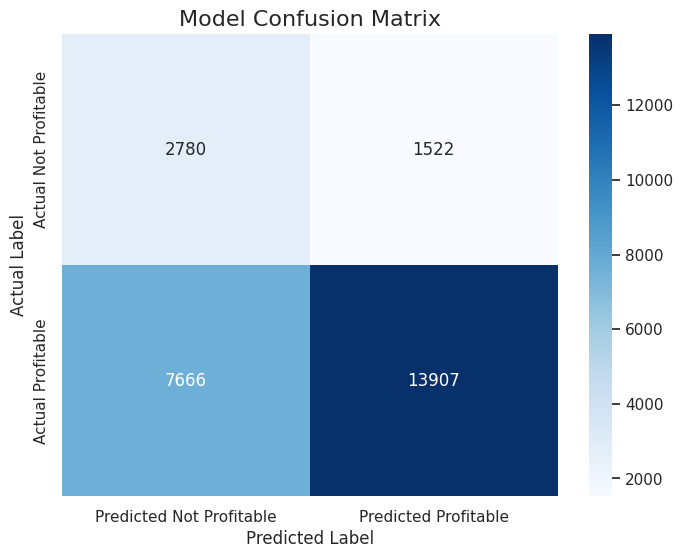


--- Step 9 Complete ---


In [9]:


print("Starting Step 9: Optional Modeling...")

# --- 1. Define Features (X) and Target (y) ---
# Note: 'leverage' not available. Using 'Size USD' and 'value' instead.
numerical_features = ['Size USD', 'value']
categorical_features = ['sentiment', 'Coin']
features = numerical_features + categorical_features
target = 'is_profitable'

df_model = df_merged[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

print(f"\nTarget variable 'is_profitable' balance:\n{y.value_counts(normalize=True)}")

# --- 2. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,    # 30% for testing
    random_state=42,  # For reproducibility
    stratify=y        # Preserve class balance
)
print(f"\nData split: {len(X_train)} training samples, {len(X_test)} testing samples.")

# --- 3. Create Pre-processing and Modeling Pipeline ---
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# --- 4. Train the Model ---
print("\nTraining Logistic Regression model...")
clf.fit(X_train, y_train)
print("Model training complete.")

# --- 5. Evaluate the Model ---
print("\nEvaluating model performance on the test set...")
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\n--- Model Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (For the 'True' class)")
print(f"Recall:    {recall:.4f} (For the 'True' class)")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Not Profitable (False)', 'Profitable (True)']))

# --- 6. Plot 7: Confusion Matrix ---
print("\nGenerating Plot 7: Model Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax,
    xticklabels=['Predicted Not Profitable', 'Predicted Profitable'],
    yticklabels=['Actual Not Profitable', 'Actual Profitable']
)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Model Confusion Matrix', fontsize=16)
save_plot("model_confusion_matrix.png", fig=fig)
plt.show()
plt.close(fig)

print("\n--- Step 9 Complete ---")

# --- END OF ANALYSIS ---

The notebook has successfully run all 9 steps.

*All CSV outputs (e.g., merged_trade_data.csv) are in the csv_files/ directory.

*All 7 plot images are in the outputs/ directory.